# Toy Model (Python, New MvLKIF)

This notebook recreates the Toy Model experiment using the new `MvLKIF` package and compares results against the original covariance-formula implementation from `Toy Model.ipynb`.

Compared quantities per path and confounder strength `gamma`:
- `T` (information flow)
- `tau` (normalized information flow)


## Simulated System Equations

State vector: $x_t=[x_1,x_2,x_3,x_4,x_5]^\top$. The simulator uses a linear VAR(1):

$$x_{t+1}=A(\gamma)\,x_t+\varepsilon_t,\quad \varepsilon_t\sim\mathcal{N}(0,\mathrm{diag}(b)^2).$$

With diagonal persistence $\phi$ and couplings:

- $x_2\to x_1$: $C_{21}$
- $x_3\to x_1$: $C_{31}$
- $x_1\to x_2$: $C_{12}$
- $x_3\to x_2$: $C_{32}$
- hidden confounder: $x_4\to x_1, x_4\to x_2$ with strength $\gamma$
- hidden layer: $x_5\to x_4$ with strength $\eta$

So the nonzero off-diagonal terms are:

$$A_{1,2}=C_{21},\;A_{1,3}=C_{31},\;A_{2,1}=C_{12},\;A_{2,3}=C_{32},\;A_{1,4}=A_{2,4}=\gamma,\;A_{4,5}=\eta.$$

Observed variables are $[x_1,x_2,x_3]$.


## Linear Equations (Component-wise)

The same system can be written explicitly as:

\[
\begin{aligned}
x_1(t+1) &= \phi\,x_1(t) + C_{21}\,x_2(t) + C_{31}\,x_3(t) + \gamma\,x_4(t) + \varepsilon_1(t),\\
x_2(t+1) &= C_{12}\,x_1(t) + \phi\,x_2(t) + C_{32}\,x_3(t) + \gamma\,x_4(t) + \varepsilon_2(t),\\
x_3(t+1) &= \phi\,x_3(t) + \varepsilon_3(t),\\
x_4(t+1) &= \phi\,x_4(t) + \eta\,x_5(t) + \varepsilon_4(t),\\
x_5(t+1) &= \phi\,x_5(t) + \varepsilon_5(t).
\end{aligned}
\]

where $\varepsilon_i(t)$ are Gaussian innovations with scales given by `B_DIAG`.


In [11]:
import numpy as np
import matplotlib.pyplot as plt

from MvLKIF import normalized_causality_est, normalized_multi_causality_est, moving_lkif

# Reproducibility / experiment size
N_SAMPLES = 3000
BURN_IN = 200
NUM_REALIZATIONS = 80
K_DIFF = 1
DT = 1.0
RNG_BASE = 54000

# Moving-LKIF settings (third comparison method)
MOVING_WINDOW = 600
MOVING_STEP = 120

# Dynamics (same as original notebook)
PHI  = 0.25
C21  = 0.05
C31  = 0.55
C12  = 0.45
C32  = 0.12
GAMMA_VALS = np.linspace(0.0, 0.8, 9)
ETA_X5_TO_X4 = 0.70
B_DIAG = np.array([0.6, 0.5, 0.5, 0.6, 0.6], dtype=float)
EPS = 1e-12


In [12]:
# Original covariance-formula helpers (from Toy Model.ipynb)

def _center(X):
    return X - X.mean(axis=0, keepdims=True)

def cov_mat(X):
    Xc = _center(X)
    return (Xc.T @ Xc) / max(1, (Xc.shape[0] - 1))

def forward_diff(x, k=1, dt=1.0):
    return (x[k:] - x[:-k]) / (k * dt)

def _var(x):
    xc = x - np.mean(x)
    return float(np.dot(xc, xc) / max(1, len(xc) - 1))

def stable_inv(C, eps=EPS):
    try:
        return np.linalg.inv(C)
    except np.linalg.LinAlgError:
        return np.linalg.inv(C + eps * np.eye(C.shape[0]))

def _cov_blocks_for_target(X, i, k=1, dt=1.0):
    Xlag = X[:-k, :]
    xdot = forward_diff(X[:, i], k=k, dt=dt)
    C = cov_mat(Xlag)
    Xlagc = _center(Xlag)
    xdotc = xdot - xdot.mean()
    n = max(1, Xlag.shape[0] - 1)
    Cxdot = (Xlagc.T @ xdotc) / n
    vardot = _var(xdot)
    return C, Cxdot, vardot

def if_and_tau_multivar_cov(X, i, j, k=1, dt=1.0, eps=EPS):
    C, Cxdot, vardot = _cov_blocks_for_target(X, i, k=k, dt=dt)
    a = stable_inv(C, eps=eps) @ Cxdot
    Cii = C[i, i] + eps

    T_all = np.zeros(C.shape[0])
    for m in range(C.shape[0]):
        if m == i:
            continue
        T_all[m] = a[m] * (C[i, m] / Cii)

    Hself = a[i]
    var_resid = vardot - 2.0 * (a @ Cxdot) + float(a.T @ C @ a)
    g = max(var_resid / dt, 0.0)
    Hnoise = g / (2.0 * Cii)

    Z = max(abs(Hself) + np.sum(np.abs(T_all)) + abs(Hnoise), eps)
    T = float(T_all[j])
    tau = float(T / Z)
    return T, tau

def if_and_tau_bivariate_cov(X2, k=1, dt=1.0, eps=EPS):
    C, Cxdot, vardot = _cov_blocks_for_target(X2, i=0, k=k, dt=dt)
    C11, C12_, C22 = C[0, 0], C[0, 1], C[1, 1]
    detC = C11 * C22 - C12_ * C12_
    if abs(detC) < eps:
        C = C + eps * np.eye(2)
        C11, C12_, C22 = C[0, 0], C[0, 1], C[1, 1]
        detC = C11 * C22 - C12_ * C12_

    a_self = ( C22 * Cxdot[0] - C12_ * Cxdot[1]) / detC
    a_par  = (-C12_ * Cxdot[0] + C11 * Cxdot[1]) / detC

    Cii = C11 + eps
    T = float(a_par * (C12_ / Cii))

    a_vec = np.array([a_self, a_par])
    var_resid = vardot - 2.0 * (a_vec @ Cxdot) + float(a_vec.T @ C @ a_vec)
    g = max(var_resid / dt, 0.0)
    Hself = a_self
    Hnoise = g / (2.0 * Cii)
    Z = max(abs(Hself) + abs(Hnoise) + abs(T), eps)
    tau = float(T / Z)
    return T, tau


In [13]:
# Simulator (same structure as original)

def simulate_var(A, b_diag, N=4000, burn=800, seed=0):
    rng = np.random.default_rng(seed)
    d = A.shape[0]
    X = np.zeros((N + burn, d))
    for t in range(N + burn - 1):
        eps = rng.normal(0.0, 1.0, size=d) * b_diag
        X[t + 1] = A @ X[t] + eps
    return X[burn:]

def build_A(gamma, eta=ETA_X5_TO_X4):
    A = np.zeros((5, 5), dtype=float)
    np.fill_diagonal(A, PHI)
    A[0, 1] = C21
    A[0, 2] = C31
    A[1, 0] = C12
    A[1, 2] = C32
    A[0, 3] = gamma
    A[1, 3] = gamma
    A[3, 4] = eta
    return A


## Simulated System Time Series ([x1,...,x5])

下面展示同一线性系统的一次模拟 realization 的 5 维状态时序。


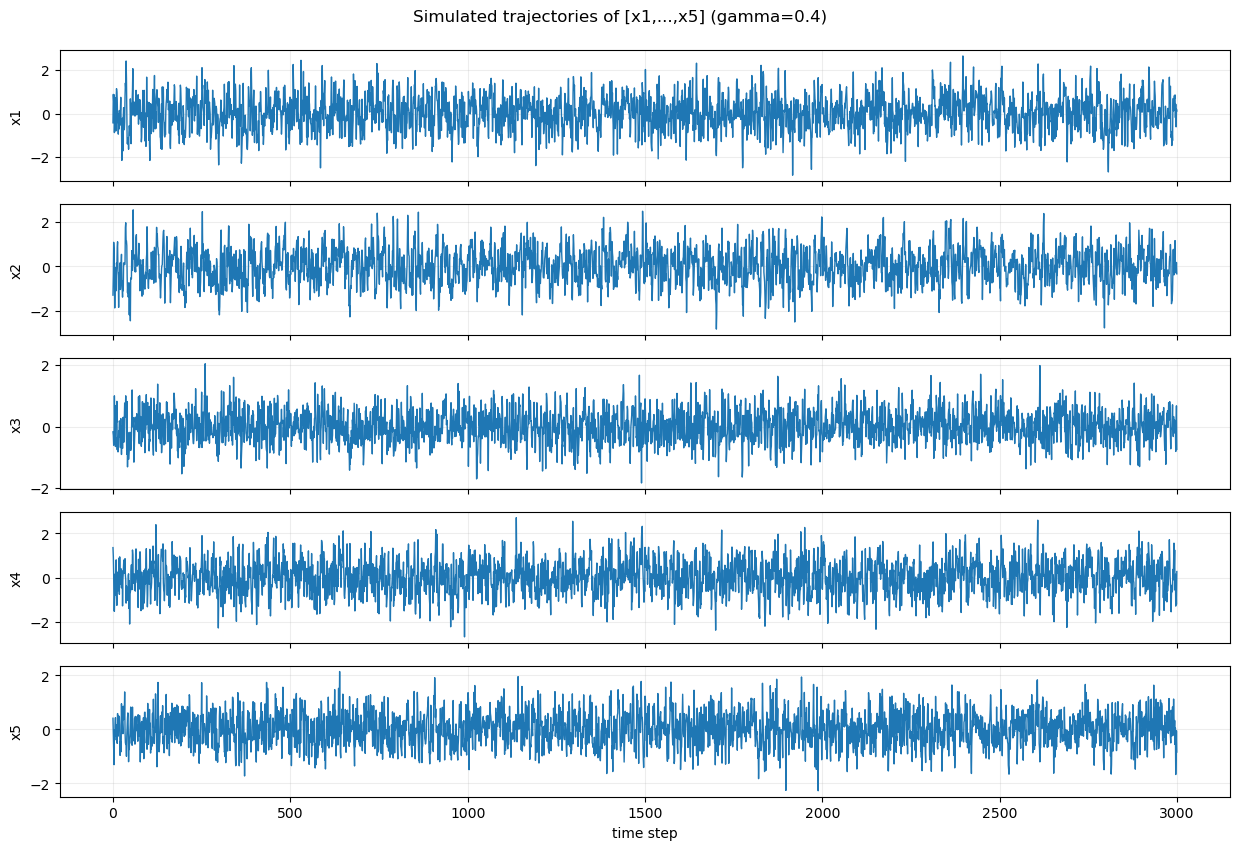

In [14]:
# Time-series view of the full 5D system [x1,...,x5]
gamma_ts = 0.4
A_ts = build_A(gamma_ts)
X_ts = simulate_var(A_ts, b_diag=B_DIAG, N=N_SAMPLES, burn=BURN_IN, seed=RNG_BASE + 7)

t_idx = np.arange(X_ts.shape[0])
fig, axes = plt.subplots(5, 1, figsize=(12.5, 8.5), sharex=True)
for i, ax in enumerate(axes):
    ax.plot(t_idx, X_ts[:, i], lw=1.0)
    ax.set_ylabel(f'x{i+1}')
    ax.grid(alpha=0.22)

axes[-1].set_xlabel('time step')
fig.suptitle(f'Simulated trajectories of [x1,...,x5] (gamma={gamma_ts})', y=0.995)
plt.tight_layout()
plt.show()



In [15]:
def _moving_scalar(Xmat, np_step=K_DIFF, window=MOVING_WINDOW, step=MOVING_STEP):
    # realization-level scalar from MovingLKIF (mean over windows)
    centers, t, tau, *_ = moving_lkif(window, step, np_step, Xmat, return_tau=True)
    _ = centers
    return float(np.nanmean(t)), float(np.nanmean(tau))


def compare_one_realization(Xobs):
    # Xobs columns: [x1, x2, x3]

    # Path 1->2
    old_T12_bi, old_tau12_bi = if_and_tau_bivariate_cov(Xobs[:, [1, 0]], k=K_DIFF, dt=DT)
    old_T12_mi, old_tau12_mi = if_and_tau_multivar_cov(Xobs, i=1, j=0, k=K_DIFF, dt=DT)
    new_T12_bi, new_tau12_bi, *_ = normalized_causality_est(Xobs[:, 1], Xobs[:, 0], K_DIFF)
    new_T12_mi, new_tau12_mi, *_ = normalized_multi_causality_est(Xobs[:, [1, 0, 2]], K_DIFF)
    mov_T12_bi, mov_tau12_bi = _moving_scalar(Xobs[:, [1, 0]])
    mov_T12_mi, mov_tau12_mi = _moving_scalar(Xobs[:, [1, 0, 2]])

    # Path 1->3
    old_T13_bi, old_tau13_bi = if_and_tau_bivariate_cov(Xobs[:, [2, 0]], k=K_DIFF, dt=DT)
    old_T13_mi, old_tau13_mi = if_and_tau_multivar_cov(Xobs, i=2, j=0, k=K_DIFF, dt=DT)
    new_T13_bi, new_tau13_bi, *_ = normalized_causality_est(Xobs[:, 2], Xobs[:, 0], K_DIFF)
    new_T13_mi, new_tau13_mi, *_ = normalized_multi_causality_est(Xobs[:, [2, 0, 1]], K_DIFF)
    mov_T13_bi, mov_tau13_bi = _moving_scalar(Xobs[:, [2, 0]])
    mov_T13_mi, mov_tau13_mi = _moving_scalar(Xobs[:, [2, 0, 1]])

    # Path 3->2
    old_T32_bi, old_tau32_bi = if_and_tau_bivariate_cov(Xobs[:, [1, 2]], k=K_DIFF, dt=DT)
    old_T32_mi, old_tau32_mi = if_and_tau_multivar_cov(Xobs, i=1, j=2, k=K_DIFF, dt=DT)
    new_T32_bi, new_tau32_bi, *_ = normalized_causality_est(Xobs[:, 1], Xobs[:, 2], K_DIFF)
    new_T32_mi, new_tau32_mi, *_ = normalized_multi_causality_est(Xobs[:, [1, 2, 0]], K_DIFF)
    mov_T32_bi, mov_tau32_bi = _moving_scalar(Xobs[:, [1, 2]])
    mov_T32_mi, mov_tau32_mi = _moving_scalar(Xobs[:, [1, 2, 0]])

    return {
        'T12_bi': (old_T12_bi, new_T12_bi, mov_T12_bi), 'tau12_bi': (old_tau12_bi, new_tau12_bi, mov_tau12_bi),
        'T12_mi': (old_T12_mi, new_T12_mi, mov_T12_mi), 'tau12_mi': (old_tau12_mi, new_tau12_mi, mov_tau12_mi),
        'T13_bi': (old_T13_bi, new_T13_bi, mov_T13_bi), 'tau13_bi': (old_tau13_bi, new_tau13_bi, mov_tau13_bi),
        'T13_mi': (old_T13_mi, new_T13_mi, mov_T13_mi), 'tau13_mi': (old_tau13_mi, new_tau13_mi, mov_tau13_mi),
        'T32_bi': (old_T32_bi, new_T32_bi, mov_T32_bi), 'tau32_bi': (old_tau32_bi, new_tau32_bi, mov_tau32_bi),
        'T32_mi': (old_T32_mi, new_T32_mi, mov_T32_mi), 'tau32_mi': (old_tau32_mi, new_tau32_mi, mov_tau32_mi),
    }


def run_comparison(gammas=GAMMA_VALS, N=N_SAMPLES, R=NUM_REALIZATIONS):
    metrics = [
        'T12_bi','tau12_bi','T12_mi','tau12_mi',
        'T13_bi','tau13_bi','T13_mi','tau13_mi',
        'T32_bi','tau32_bi','T32_mi','tau32_mi',
    ]

    old_mean = {k: [] for k in metrics}
    new_mean = {k: [] for k in metrics}
    mov_mean = {k: [] for k in metrics}
    abs_diff_mean_new = {k: [] for k in metrics}
    abs_diff_mean_mov = {k: [] for k in metrics}

    for gamma in gammas:
        A = build_A(gamma)
        old_vals = {k: [] for k in metrics}
        new_vals = {k: [] for k in metrics}
        mov_vals = {k: [] for k in metrics}

        for r in range(R):
            seed = RNG_BASE + 10000 * int(100 * gamma) + 17 * r
            X = simulate_var(A, b_diag=B_DIAG, N=N, burn=BURN_IN, seed=seed)
            Xobs = X[:, [0, 1, 2]]
            res = compare_one_realization(Xobs)

            for k in metrics:
                o, n, m = res[k]
                old_vals[k].append(o)
                new_vals[k].append(n)
                mov_vals[k].append(m)

        for k in metrics:
            oarr = np.asarray(old_vals[k], dtype=float)
            narr = np.asarray(new_vals[k], dtype=float)
            marr = np.asarray(mov_vals[k], dtype=float)
            old_mean[k].append(float(np.mean(oarr)))
            new_mean[k].append(float(np.mean(narr)))
            mov_mean[k].append(float(np.mean(marr)))
            abs_diff_mean_new[k].append(float(np.mean(np.abs(narr - oarr))))
            abs_diff_mean_mov[k].append(float(np.mean(np.abs(marr - oarr))))

    return {
        'gammas': np.asarray(gammas, dtype=float),
        'old_mean': old_mean,
        'new_mean': new_mean,
        'moving_mean': mov_mean,
        'abs_diff_mean_new': abs_diff_mean_new,
        'abs_diff_mean_moving': abs_diff_mean_mov,
    }


In [16]:
cmp = run_comparison()

# compact numeric summary
all_metrics = list(cmp['old_mean'].keys())
print('Metric                      max|new-old|   max|moving-old|   mean|new-old|   mean|moving-old|')
for k in all_metrics:
    oldm = np.asarray(cmp['old_mean'][k])
    newm = np.asarray(cmp['new_mean'][k])
    movm = np.asarray(cmp['moving_mean'][k])
    d1 = np.max(np.abs(newm - oldm))
    d2 = np.max(np.abs(movm - oldm))
    d3 = np.mean(np.asarray(cmp['abs_diff_mean_new'][k]))
    d4 = np.mean(np.asarray(cmp['abs_diff_mean_moving'][k]))
    print(f"{k:24s}  {d1: .3e}    {d2: .3e}    {d3: .3e}    {d4: .3e}")


Metric                      max|new-old|   max|moving-old|   mean|new-old|   mean|moving-old|
T12_bi                     5.551e-17     1.205e-03     9.369e-17     2.988e-03
tau12_bi                   5.551e-17     1.342e-03     4.988e-17     2.233e-03
T12_mi                     1.110e-16     1.176e-03     8.321e-17     2.911e-03
tau12_mi                   1.388e-17     1.463e-03     4.641e-17     2.229e-03
T13_bi                     1.382e-18     5.479e-04     4.210e-18     6.470e-04
tau13_bi                   1.179e-18     4.426e-04     3.442e-18     5.317e-04
T13_mi                     1.504e-18     3.535e-04     4.338e-18     6.920e-04
tau13_mi                   1.342e-18     2.880e-04     3.554e-18     5.679e-04
T32_bi                     8.674e-19     3.360e-04     1.628e-18     7.264e-04
tau32_bi                   8.674e-19     4.449e-04     1.771e-18     8.312e-04
T32_mi                     4.337e-19     2.694e-04     8.768e-19     5.379e-04
tau32_mi                   4.337e-19 

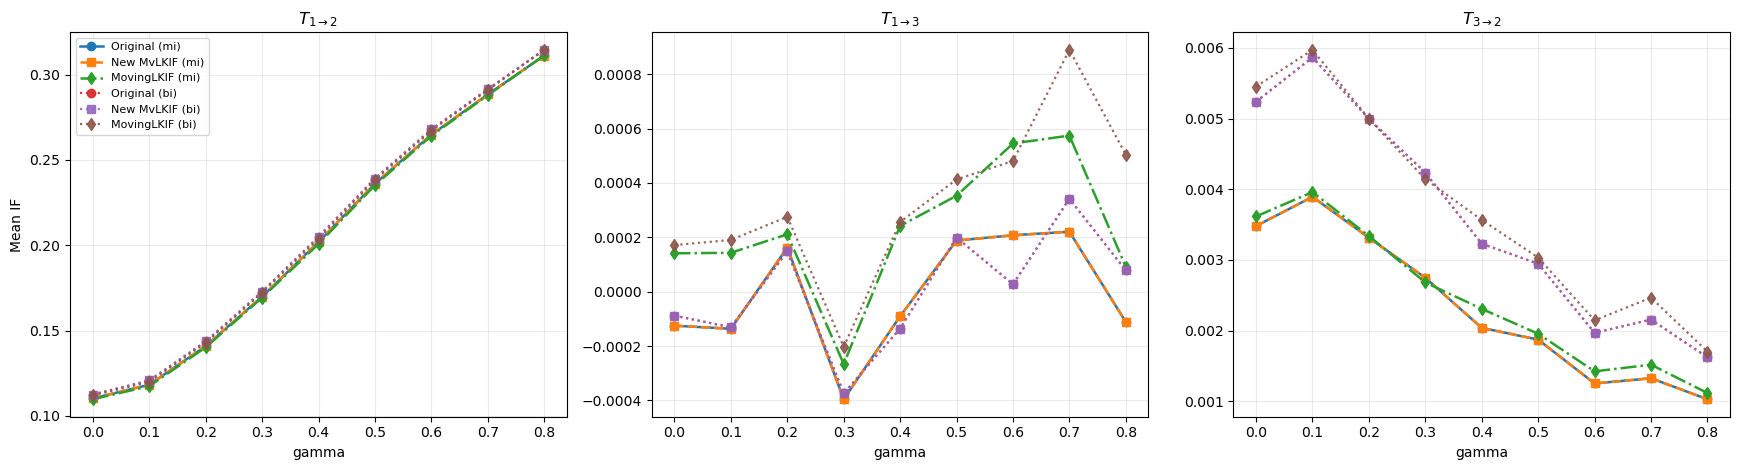

In [20]:
# Visual comparison for three representative metrics (mi + bi)
G = cmp['gammas']
fig, axes = plt.subplots(1, 3, figsize=(17.5, 4.8), sharex=True)

pairs = [
    ('T12_mi', 'T12_bi', r'$T_{1\to2}$'),
    ('T13_mi', 'T13_bi', r'$T_{1\to3}$'),
    ('T32_mi', 'T32_bi', r'$T_{3\to2}$'),
]

for ax, (k_mi, k_bi, title) in zip(axes, pairs):
    # multivariate conditional (mi)
    ax.plot(G, cmp['old_mean'][k_mi], 'o-',  label='Original (mi)', lw=1.8)
    ax.plot(G, cmp['new_mean'][k_mi], 's--', label='New MvLKIF (mi)', lw=1.8)
    ax.plot(G, cmp['moving_mean'][k_mi], 'd-.', label='MovingLKIF (mi)', lw=1.8)

    # bivariate (bi)
    ax.plot(G, cmp['old_mean'][k_bi], 'o:',  label='Original (bi)', lw=1.6, alpha=0.9)
    ax.plot(G, cmp['new_mean'][k_bi], 's:',  label='New MvLKIF (bi)', lw=1.6, alpha=0.9)
    ax.plot(G, cmp['moving_mean'][k_bi], 'd:', label='MovingLKIF (bi)', lw=1.6, alpha=0.9)

    ax.set_title(title)
    ax.set_xlabel('gamma')
    ax.grid(alpha=0.25)

axes[0].set_ylabel('Mean IF')
axes[0].legend(loc='best', fontsize=8)
plt.tight_layout()
plt.show()



## Interpretation

- `New MvLKIF (static)` should match the original covariance formulas to near machine precision.
- `MovingLKIF` is a windowed estimator, so it is expected to differ from full-sample static estimates.
- The `moving` vs `old` columns quantify the bias/variance tradeoff introduced by finite windows (`MOVING_WINDOW`, `MOVING_STEP`).


## New Test: Time-Varying Comparison on Steps 1000-2000

Using the same simulated system, we generate one realization with `N=3000` and compare
three LKIF paths on the segment `[1000, 2000)`:

- $T_{1\to2|3}$
- $T_{1\to3|2}$
- $T_{3\to2|1}$

Methods compared:
- `kal_lkif` (Kalman time-varying LKIF)
- `moving_lkif` (windowed moving estimator)
- Original covariance formula with rolling window (`if_and_tau_multivar_cov`)


In [ ]:
from MvLKIF import kal_lkif, moving_lkif, normalized_multi_causality_est
from MvLKIF.core.kal_lkif import KalLKIF, _tau_ci_analytic_series


def rolling_old_multivar_series(X, i, j, window=300, step=1):
    centers, t_vals, tau_vals = [], [], []
    n = X.shape[0]
    for s in range(0, n - window + 1, step):
        sub = X[s:s + window, :]
        t, tau = if_and_tau_multivar_cov(sub, i=i, j=j, k=K_DIFF, dt=DT)
        centers.append(s + window // 2)
        t_vals.append(t)
        tau_vals.append(tau)
    return np.asarray(centers), np.asarray(t_vals), np.asarray(tau_vals)


def moving_tau_ci_analytic(Xm, window, step, np_step, level=0.95):
    starts = list(range(0, Xm.shape[0] - window + 1, step))
    key = f"{int(round(100 * level))}"
    lo, hi = [], []
    for s in starts:
        sub = Xm[s:s + window, :]
        out = normalized_multi_causality_est(sub, np_step, tau_ci_method='analytic', levels=(level,))
        tau_ci = out[-1]
        band = np.asarray(tau_ci[key], dtype=float).reshape(2)
        lo.append(band[0])
        hi.append(band[1])
    return np.asarray(lo), np.asarray(hi)


# one realization from the same system
gamma_test = 0.4
A_test = build_A(gamma_test)
X_full = simulate_var(A_test, b_diag=B_DIAG, N=3000, burn=BURN_IN, seed=RNG_BASE + 123)
Xobs_full = X_full[:, [0, 1, 2]]

seg_start, seg_end = 1000, 2000
Xseg = Xobs_full[seg_start:seg_end, :]  # [x1,x2,x3]
seg_t = np.arange(seg_start, seg_end)

# path definitions: name, target, source, conditioner (indices in [x1,x2,x3])
paths = [
    (r'$T_{1\to2|3}$', 1, 0, 2),
    (r'$T_{1\to3|2}$', 2, 0, 1),
    (r'$T_{3\to2|1}$', 1, 2, 0),
]

window = 300
step = 1

# collect reusable per-path series for both T and tau figures
path_cache = []
for title, i_tgt, j_src, k_cond in paths:
    t_kal, tau_kal, e90_kal, e95_kal, e99_kal = kal_lkif(
        24, 90, 'UWMA', K_DIFF, Xseg[:, i_tgt], Xseg[:, j_src], Xseg[:, k_cond]
    )
    t_kal = np.asarray(t_kal).reshape(-1)
    tau_kal = np.asarray(tau_kal).reshape(-1)
    e95_kal = np.asarray(e95_kal).reshape(-1)

    # tau CI from dedicated series function (not back-calculated from T errors)
    _, _, _, _, _, var_t21_kal = KalLKIF(
        [Xseg[:, i_tgt], Xseg[:, j_src], Xseg[:, k_cond]],
        24,
        90,
        'UWMA',
        K_DIFF,
        reverse=False,
        return_tau=True,
        return_var_t21=True,
    )
    tau_ci_kal = _tau_ci_analytic_series(
        t_kal,
        tau_kal,
        np.asarray(var_t21_kal).reshape(-1),
        levels=(0.95,),
    )
    tau_lo_kal = tau_ci_kal['95'][:, 0]
    tau_hi_kal = tau_ci_kal['95'][:, 1]

    Xm = Xseg[:, [i_tgt, j_src, k_cond]]
    c_mov, t_mov, tau_mov, e90_mov, e95_mov, e99_mov = moving_lkif(window, step, K_DIFF, Xm, return_tau=True)
    c_mov_global = c_mov + seg_start
    t_mov = np.asarray(t_mov).reshape(-1)
    tau_mov = np.asarray(tau_mov).reshape(-1)
    e95_mov = np.asarray(e95_mov).reshape(-1)

    # moving window tau CI from normalized estimator analytic CI per window
    tau_lo_mov, tau_hi_mov = moving_tau_ci_analytic(Xm, window, step, K_DIFF, level=0.95)

    c_old, t_old, tau_old = rolling_old_multivar_series(Xseg, i=i_tgt, j=j_src, window=window, step=step)
    c_old_global = c_old + seg_start

    path_cache.append({
        'title': title,
        'seg_t': seg_t,
        't_kal': t_kal,
        'tau_kal': tau_kal,
        'e95_kal': e95_kal,
        'tau_lo_kal': tau_lo_kal,
        'tau_hi_kal': tau_hi_kal,
        'c_mov_global': c_mov_global,
        't_mov': t_mov,
        'tau_mov': tau_mov,
        'e95_mov': e95_mov,
        'tau_lo_mov': tau_lo_mov,
        'tau_hi_mov': tau_hi_mov,
        'c_old_global': c_old_global,
        't_old': t_old,
        'tau_old': tau_old,
    })


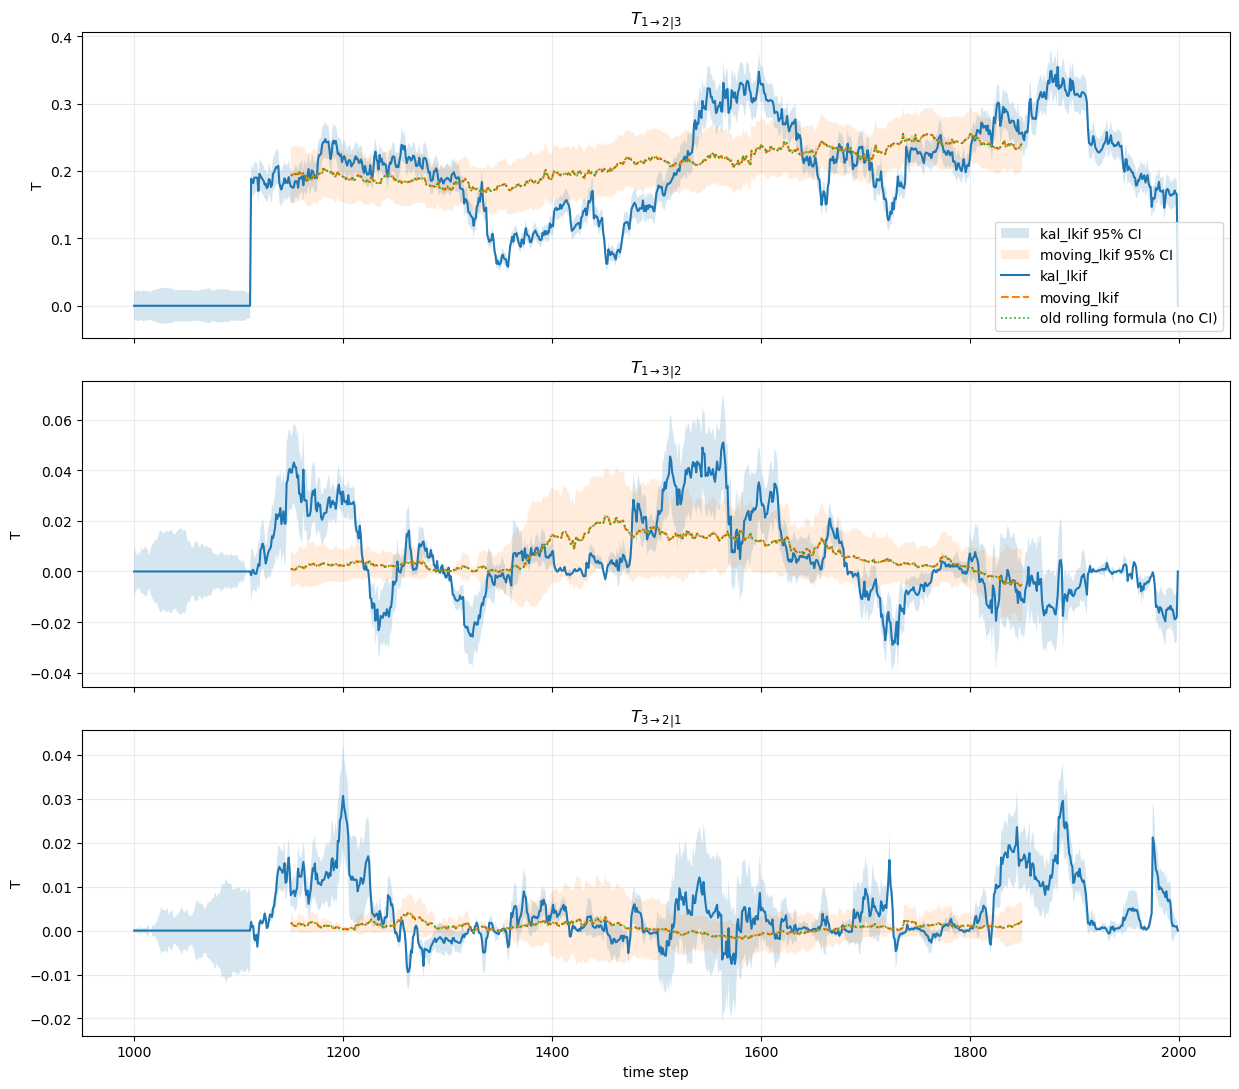

Segment: [1000, 2000), gamma=0.4, window=300, step=1
T plot: 95% confidence bands are shown for kal_lkif and moving_lkif.


In [ ]:

# ----- T plot only -----
fig, axes = plt.subplots(3, 1, figsize=(12.5, 11), sharex=True)
for ax, d in zip(axes, path_cache):
    ax.fill_between(d['seg_t'], d['t_kal'] - d['e95_kal'], d['t_kal'] + d['e95_kal'], alpha=0.18, label='kal_lkif 95% CI')
    ax.fill_between(d['c_mov_global'], d['t_mov'] - d['e95_mov'], d['t_mov'] + d['e95_mov'], alpha=0.14, label='moving_lkif 95% CI')

    ax.plot(d['seg_t'], d['t_kal'], lw=1.5, label='kal_lkif')
    ax.plot(d['c_mov_global'], d['t_mov'], lw=1.5, ls='--', label='moving_lkif')
    ax.plot(d['c_old_global'], d['t_old'], lw=1.2, ls=':', label='old rolling formula (no CI)')
    ax.set_title(d['title'])
    ax.set_ylabel('T')
    ax.grid(alpha=0.25)

axes[-1].set_xlabel('time step')
axes[0].legend(loc='best')
plt.tight_layout()
plt.show()

print(f'Segment: [{seg_start}, {seg_end}), gamma={gamma_test}, window={window}, step={step}')
print('T plot: 95% confidence bands are shown for kal_lkif and moving_lkif.')



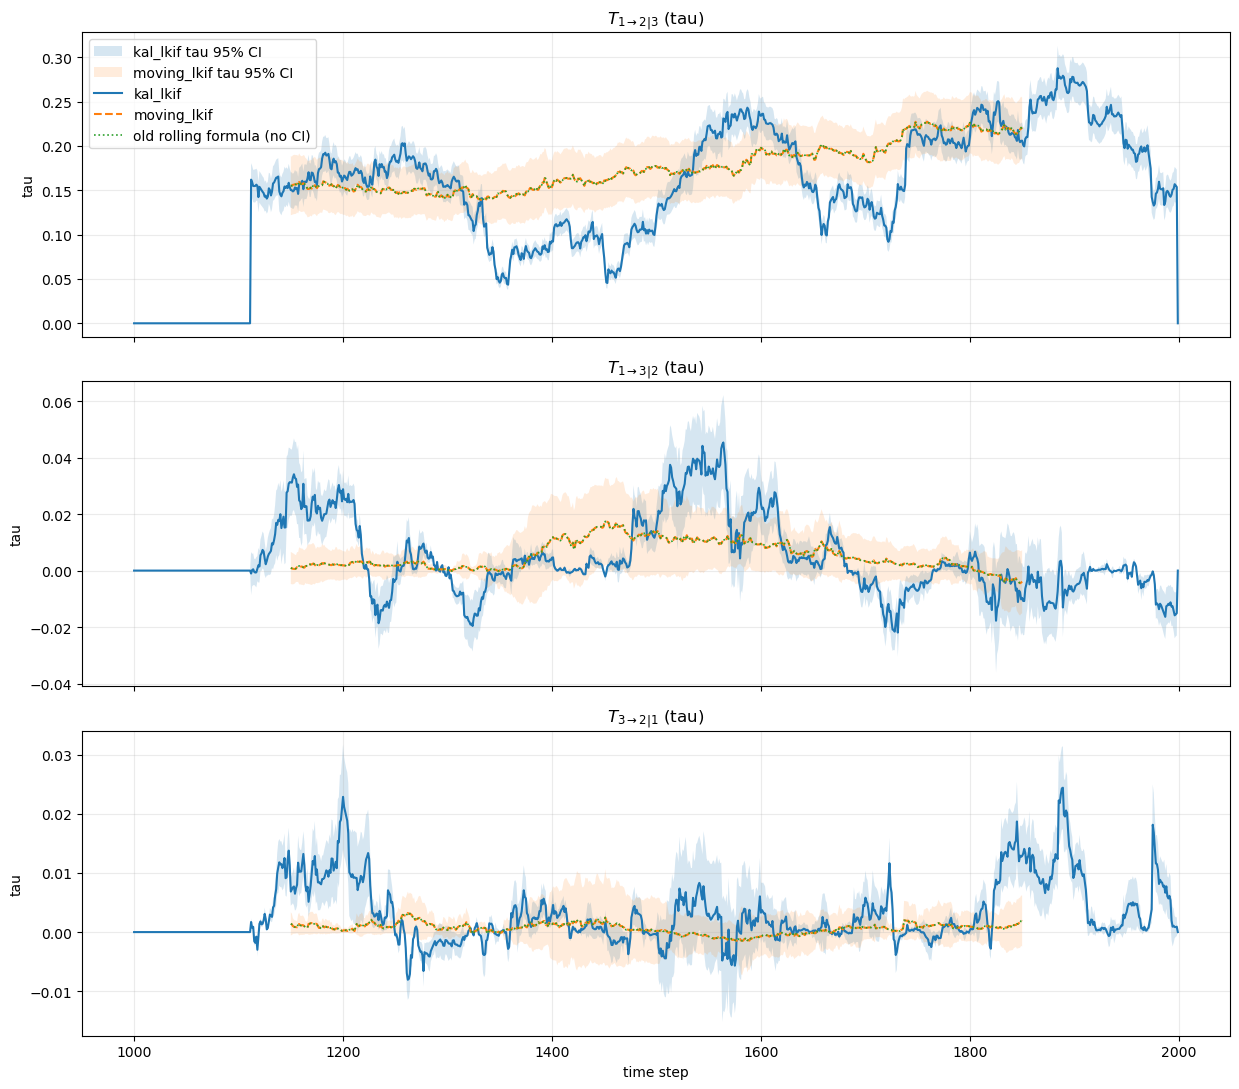

tau plot: 95% confidence bands are computed from dedicated tau CI methods (not from T errors).


In [22]:
# ----- tau plot only (with 95% CI) -----
fig_tau, axes_tau = plt.subplots(3, 1, figsize=(12.5, 11), sharex=True)
for ax, d in zip(axes_tau, path_cache):
    ax.fill_between(d['seg_t'], d['tau_lo_kal'], d['tau_hi_kal'], alpha=0.18, label='kal_lkif tau 95% CI')
    ax.fill_between(d['c_mov_global'], d['tau_lo_mov'], d['tau_hi_mov'], alpha=0.14, label='moving_lkif tau 95% CI')

    ax.plot(d['seg_t'], d['tau_kal'], lw=1.5, label='kal_lkif')
    ax.plot(d['c_mov_global'], d['tau_mov'], lw=1.5, ls='--', label='moving_lkif')
    ax.plot(d['c_old_global'], d['tau_old'], lw=1.2, ls=':', label='old rolling formula (no CI)')
    ax.set_title(d['title'] + ' (tau)')
    ax.set_ylabel('tau')
    ax.grid(alpha=0.25)

axes_tau[-1].set_xlabel('time step')
axes_tau[0].legend(loc='best')
plt.tight_layout()
plt.show()

print('tau plot: 95% confidence bands are computed from dedicated tau CI methods (not from T errors).')

